In [1]:
!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely
!pip install imgaug
!pip install --upgrade scikit-image


    100% |████████████████████████████████| 17.3MB 2.2MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
tensorflow 1.13.1 has requirement tensorboard<1.14.0,>=1.13.0, but you'll have tensorboard 1.12.2 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


    100% |████████████████████████████████| 25.3MB 1.9MB/s 
    100% |████████████████████████████████| 2.0MB 13.5MB/s 
    100% |████████████████████████████████| 706kB 25.5MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
distributed 1.26.0 has requirement tornado>=5, but you'll have tornado 4.5.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Found existing installation: dask 0.20.2
    Uninstalling dask-0.20.2:
      Successfully uninstalled dask-0.20.2
  Found existing installation: scikit-image 0.13.1
    Uninstalling scikit-image-0.13.1:
      Successfully uninstalled scikit-image-0.13.1


In [1]:
from keras.preprocessing import image
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import h5py

from imgaug import augmenters as iaa
import imgaug as ia

import math
import tensorflow as tf

from PIL import Image

from skimage import color

import cv2

from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/Colab/datasets/labels"

resizedWidth = 384
resizedShortRatio = 384 / 700
resizedLongRatio = 384 / 1000
gridCount = 12

Using TensorFlow backend.


KeyboardInterrupt: ignored

In [0]:
def getImageData():


  imagePixelData = np.zeros((200, resizedWidth, resizedWidth, 3))
  imageLocationData = np.zeros((200, gridCount, gridCount, 8))

  groups = ["G", "I", "H", "J"]

  count = 0

  # separate each image to 20 grids, since there is low chance that there will be multiple hairs in one grid, no anchor box is necessary

  # for each grid
  # 1. boolean for whether there is an object
  # 2. bx, by, bw, bh
  # 3. classes (3 for hairs)

  # therefore the output size should be 20 x 20 x 8

  for groupName in groups:
    labelPath = "/content/gdrive/My Drive/Colab/datasets/labels/image_boxes_" + groupName + ".txt"
    with open(labelPath) as file:
      boundingBoxLocations = eval(file.read())
      imagePath = "/content/gdrive/My Drive/Colab/datasets/" + groupName + "/" + groupName + "_data/"
      for pictureID, boxLocation in boundingBoxLocations.items():
#         picture = image.load_img(imagePath + pictureID + ".png", target_size=(resizedWidth,resizedWidth), color_mode="grayscale")
        picture = image.load_img(imagePath + pictureID + ".png", target_size=(resizedWidth,resizedWidth))
        pixelVal = image.img_to_array(picture) / 255.0
        
        imagePixelData[count] = pixelVal

        gridData = np.zeros((gridCount, gridCount, 8))
        gridSize = resizedWidth // gridCount

        for eachBox in boxLocation:

          eachBox[0] = eachBox[0] * resizedLongRatio
          eachBox[2] = eachBox[2] * resizedLongRatio
          
          ## Images in G are in different dimensions than other images
          if groupName == 'G':   
            eachBox[1] = eachBox[1] * resizedLongRatio
            eachBox[3] = eachBox[3] * resizedLongRatio
          else:      
            eachBox[1] = eachBox[1] * resizedShortRatio
            eachBox[3] = eachBox[3] * resizedShortRatio

          gridX = int(eachBox[0] // gridSize)
          gridY = int(eachBox[1] // gridSize)
          

          gridCenterX = eachBox[0] % gridSize / gridSize
          gridCenterY = eachBox[1] % gridSize / gridSize

          # width and height according to grid box ratio
#           gridBoxWidth = eachBox[2] / gridSize
#           gridBoxHeight = eachBox[3] / gridSize

#           boolAndPos = np.array([1, gridCenterX, gridCenterY, gridBoxWidth, gridBoxHeight])

          # width and height according to image ratio
          gridBoxWidth = eachBox[2] / resizedWidth
          gridBoxHeight = eachBox[3] / resizedWidth

          boolAndPos = np.array([1, gridCenterX, gridCenterY, gridBoxWidth, gridBoxHeight])
        
          classes = np.eye(3, dtype=np.float32)[eachBox[4]]

          gridData[gridY][gridX] = np.append(boolAndPos,classes)

        imageLocationData[count] = gridData

        count += 1
        if count % 50 == 0:
          print("count =", count)
  
  return imagePixelData, imageLocationData

In [0]:
def getAugmentedData(augmentations):
  print("Begin augmenting")
  augmentedImagePixelData = np.zeros((200, resizedWidth, resizedWidth, 3))
  augmentedImageLocationData = np.zeros((200, gridCount, gridCount, 8))

  groups = ["G", "I", "H", "J"]

  count = 0

  for groupName in groups:
    labelPath = "/content/gdrive/My Drive/Colab/datasets/labels/image_boxes_" + groupName + ".txt"
    with open(labelPath) as file:
      boundingBoxLocations = eval(file.read())
      imagePath = "/content/gdrive/My Drive/Colab/datasets/" + groupName + "/" + groupName + "_data/"
      for pictureID, boxLocations in boundingBoxLocations.items():
#         picture = image.load_img(imagePath + pictureID + ".png", target_size=(resizedWidth,resizedWidth), color_mode="grayscale")
        picture = image.load_img(imagePath + pictureID + ".png", target_size=(resizedWidth,resizedWidth))
        pixelVal = image.img_to_array(picture) / 255.0
        
        boxLocations = boxLocations
        augmentedBox = []
        for i in range(len(boxLocations)):
          centerX = boxLocations[i][0] * resizedLongRatio
          width = boxLocations[i][2] * resizedLongRatio
          
          ## Images in G are in different dimensions than other images
          centerY = 0 
          height = 0 
          
          if groupName == 'G':   
            centerY = boxLocations[i][1] * resizedLongRatio
            height = boxLocations[i][3] * resizedLongRatio
          else:      
            centerY = boxLocations[i][1] * resizedShortRatio
            height = boxLocations[i][3] * resizedShortRatio
          

          topX = centerX - width / 2
          topY = centerY - height / 2
          botX = centerX + width / 2
          botY = centerY + height / 2

          augmentedBox.append(ia.BoundingBox(x1 = topX, y1 = topY, x2 = botX, y2 = botY))

        bbs = ia.BoundingBoxesOnImage(augmentedBox, shape=(resizedWidth, resizedWidth))
        
        seq = iaa.Sequential(augmentations)

        seq_det = seq.to_deterministic()
        augmentedImage = seq_det.augment_image(pixelVal)
        augmentedBBs = seq_det.augment_bounding_boxes(bbs).remove_out_of_image().clip_out_of_image()

        augmentedImagePixelData[count] = augmentedImage

        gridData = np.zeros((gridCount, gridCount, 8))
        gridSize = resizedWidth // gridCount

        for i in range(len(augmentedBBs.bounding_boxes)):
          augmentedBox = augmentedBBs.bounding_boxes[i]
          augmentedTopX = augmentedBox.x1
          augmentedTopY = augmentedBox.y1
          augmentedBotX = augmentedBox.x2
          augmentedBotY = augmentedBox.y2

          augmentedWidth = math.fabs(augmentedBotX - augmentedTopX)
          augmentedHeight = math.fabs(augmentedBotY - augmentedTopY)

          augmentedCenterX = augmentedTopX + augmentedWidth / 2
          augmentedCenterY = augmentedTopY + augmentedHeight / 2

          gridX = int(augmentedCenterX // gridSize)
          gridY = int(augmentedCenterY // gridSize)

          if (gridX < gridCount and gridY < gridCount):
            gridCenterX = augmentedCenterX % gridSize / gridSize
            gridCenterY = augmentedCenterY % gridSize / gridSize

#             gridBoxWidth = augmentedWidth / gridSize
#             gridBoxHeight = augmentedHeight / gridSize

#             boolAndPos = np.array([1, gridCenterX, gridCenterY, gridBoxWidth, gridBoxHeight])

            gridBoxWidth = augmentedWidth / resizedWidth
            gridBoxHeight = augmentedHeight / resizedWidth

            boolAndPos = np.array([1, gridCenterX, gridCenterY, gridBoxWidth, gridBoxHeight])
      
            classes = np.eye(3, dtype=np.float32)[boxLocations[i][4]]

            gridData[gridY][gridX] = np.append(boolAndPos,classes)

        augmentedImageLocationData[count] = gridData
        count += 1
        if count % 50 == 0:
          print("count =", count)
        
  return augmentedImagePixelData, augmentedImageLocationData


In [0]:
augmentation1 = [
    iaa.Multiply((1.2, 1.5)),
    iaa.Affine(scale = {
            "x" : (0.5, 1.0),
            "y" : (0.5, 1.0)
        },
        translate_percent = {
            "x" : (-0.2, 0.2),
            "y" : (-0.2, 0.2)
    },
    shear = (-10, 10)          
    ),
    iaa.Crop(px = (0, 16)), # crop images from each side by 0 to 16px
    iaa.ContrastNormalization((0.8, 1.25)),
]

augmentation2 = [
    iaa.Fliplr(0.8), # horizontal flip 70%
    iaa.ContrastNormalization((0.75, 1.5)),
    iaa.Crop(px = (0, 16)), # crop images from each side by 0 to 16px
    iaa.GaussianBlur(sigma=(0, 2.0)), # blur images with a sigma of 0 to 3
    iaa.Affine(
      translate_px = {"x" : 10, "y": -10},
      scale = (0.7, 0.6)
    )
]

augmentation3 = [
    iaa.Flipud(0.7), # vertical flip by 70%
    iaa.Fliplr(0.4),
    iaa.ContrastNormalization((0.8, 1.25)),
    iaa.Affine(
      translate_px = {"x" : 10, "y": -10},
      scale = (0.7, 0.6)
    ),
    iaa.AverageBlur(k=(1,3)),
    iaa.Crop(px = (10, 18))
]

In [0]:
def writePreprocessedData(imageData, locationData):
  hf = h5py.File("/content/gdrive/My Drive/Colab/datasets/hairData.h5", "w")
  hf.create_dataset("hair_data", data=imageData)
  hf.create_dataset("hair_target", data=locationData)
  hf.close()
  return

def loadDatasets():
  hf = h5py.File("/content/gdrive/My Drive/Colab/datasets/hairData.h5", "r")
  pixel = np.array(hf.get("hair_data"))
  location = np.array(hf.get("hair_target"))
  hf.close()
  return pixel, location

In [6]:
imagePixelData, imageLocationData = getImageData()
print("imagePixelData shape =", imagePixelData.shape)
print("imageLocationData shape =", imageLocationData.shape)

count = 50
count = 100
count = 150
count = 200
imagePixelData shape = (200, 384, 384, 3)
imageLocationData shape = (200, 12, 12, 8)


In [7]:
augmentedImagePixelData, augmentedImageLocationData = getAugmentedData(augmentation1)
print("augmentedImagePixelData shape =", augmentedImagePixelData.shape)
print("augmentedImageLocationData shape =", augmentedImageLocationData.shape)

Begin augmenting
count = 50
count = 100
count = 150
count = 200
augmentedImagePixelData shape = (200, 384, 384, 3)
augmentedImageLocationData shape = (200, 12, 12, 8)


In [8]:
augmentedImagePixelData2, augmentedImageLocationData2 = getAugmentedData(augmentation2)
print("augmentedImagePixelData2 shape =", augmentedImagePixelData2.shape)
print("augmentedImageLocationData2 shape =", augmentedImageLocationData2.shape)

Begin augmenting
count = 50
count = 100
count = 150
count = 200
augmentedImagePixelData2 shape = (200, 384, 384, 3)
augmentedImageLocationData2 shape = (200, 12, 12, 8)


In [9]:
augmentedImagePixelData3, augmentedImageLocationData3 = getAugmentedData(augmentation3)
print("augmentedImagePixelData3 shape =", augmentedImagePixelData3.shape)
print("augmentedImageLocationData3 shape =", augmentedImageLocationData3.shape)

Begin augmenting
count = 50
count = 100
count = 150
count = 200
augmentedImagePixelData3 shape = (200, 384, 384, 3)
augmentedImageLocationData3 shape = (200, 12, 12, 8)


In [10]:
newPixelData = np.zeros((800, resizedWidth, resizedWidth, 3))
newLocationData = np.zeros((800, gridCount, gridCount, 8))
newPixelData[:200] = imagePixelData
newPixelData[200:400] = augmentedImagePixelData
newPixelData[400:600] = augmentedImagePixelData2
newPixelData[600:800] = augmentedImagePixelData3

newLocationData[:200] = imageLocationData
newLocationData[200:400] = augmentedImageLocationData
newLocationData[400:600] = augmentedImageLocationData2
newLocationData[600:800] = augmentedImageLocationData3

indices = np.random.permutation(800)
newPixelData = newPixelData[indices]
newLocationData = newLocationData[indices]

print(newPixelData.shape)
print(newLocationData.shape)

(800, 384, 384, 3)
(800, 12, 12, 8)


In [0]:
writePreprocessedData(newPixelData, newLocationData)

In [13]:
newPixelData, newLocationData = loadDatasets()
print(newPixelData.shape)
print(newLocationData.shape)

(800, 384, 384, 3)
(800, 12, 12, 8)


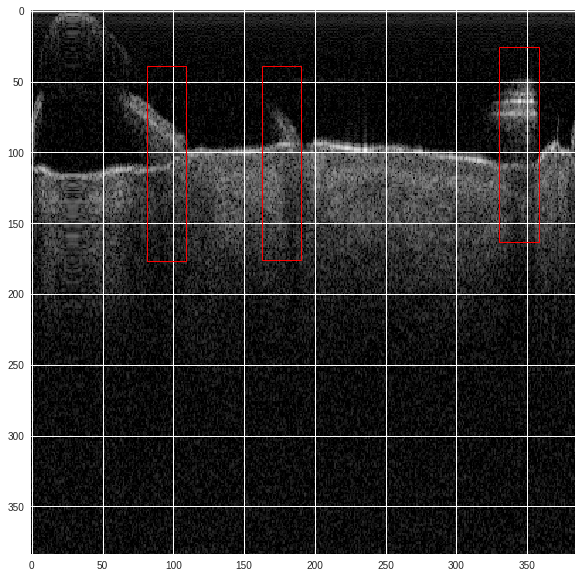

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


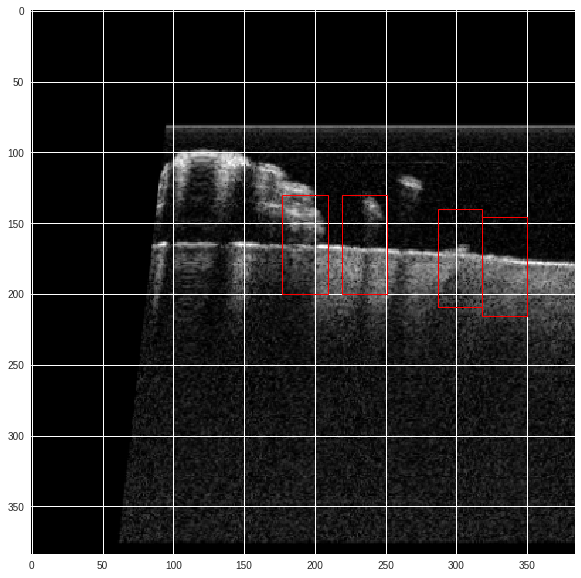

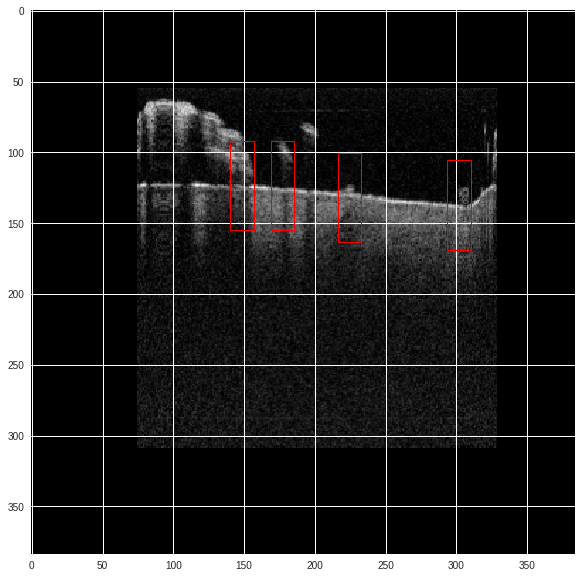

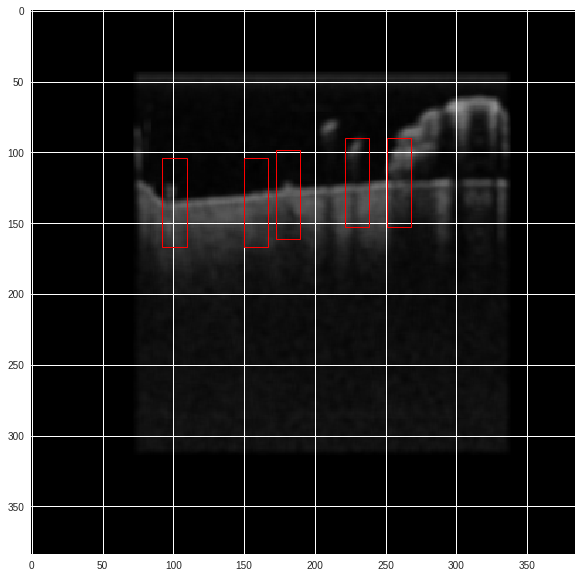

In [15]:
def displayBoundingBoxOnImage(picture, curr):

  # Create figure and axes
  fig,ax = plt.subplots(figsize=(gridCount,10))
  
  # squeeze dimension from (width, height, color) -> (width, height)
#   squeezed = np.squeeze(picture, axis = 2)
  
  # Display the image
#   ax.imshow(squeezed)

  ax.imshow(picture)
  gridSize = resizedWidth // gridCount

  for ygrid in range(gridCount):
    for xgrid in range(gridCount):
      if curr[ygrid][xgrid][0] != 0:
        offsetX = xgrid * gridSize
        offsetY = ygrid * gridSize

        centerX = curr[ygrid][xgrid][1] * gridSize + offsetX
        centerY = curr[ygrid][xgrid][2] * gridSize + offsetY

#         width = curr[ygrid][xgrid][3] * gridSize
#         height = curr[ygrid][xgrid][4] * gridSize

        width = curr[ygrid][xgrid][3] * resizedWidth
        height = curr[ygrid][xgrid][4] * resizedWidth
    
        topX = centerX - width / 2
        topY = centerY - height / 2

        # Create a Rectangle patch
        rect = patches.Rectangle((topX,topY),width,height,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

  plt.show()
  
displayBoundingBoxOnImage(imagePixelData[100], imageLocationData[100])
displayBoundingBoxOnImage(augmentedImagePixelData[0], augmentedImageLocationData[0])
displayBoundingBoxOnImage(augmentedImagePixelData2[0], augmentedImageLocationData2[0])
displayBoundingBoxOnImage(augmentedImagePixelData3[0], augmentedImageLocationData3[0])


# test = color.rgb2grey(imagePixelData[0])
# print(test.shape)


# test = cv2.imread("/content/gdrive/My Drive/Colab/datasets/G/G_data/0020.png", 0)
# print(test.shape)
# test = cv2.cvtColor(imagePixelData[0], cv2.COLOR_BGR2GRAY)
# print(test.shape)


# displayBoundingBoxOnImage(test, imageLocationData[0])

# np.squeeze(imagePixelData[0], axis = 2).shape